
# Exploring contrastive and non-contrastive methods for computer vision

This notebook contains the second exercise for the NORA research summer school on self-supervised learning. The exercise in this notebook is pre-training a convolutional neural network using contrastive and non-contrastive approaches and fine-tuning the network for classification.

The notebook is seperated into several segments with both complete code and code with missing components. Your job is to fill in the missing component.

Remember to enable GPU processing: edit -> notebook settings -> hardware accelerator -> GPU.


In [2]:
#@title Code for importing packages

import torch
import torch.nn as nn
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader
from IPython.display import clear_output
from torchvision import datasets, transforms, models

#Creating the data

The following code creates the data and plots some example images. We will use the STL-10 datset ([link torchvision description](https://pytorch.org/vision/stable/generated/torchvision.datasets.STL10.html), [link official description description](https://cs.stanford.edu/~acoates/stl10/)) in our experiments. Please follow the second link to learn about the dataset.

The data is split into a small, labeled training dataset, a larger unlabeled training dataset, and a labeled dataset for testing.

100%|██████████| 2640397119/2640397119 [01:24<00:00, 31209316.47it/s]


Extracting /content/sample_data/stl10_binary.tar.gz to /content/sample_data
torch.Size([50, 3, 96, 96]) torch.Size([50])


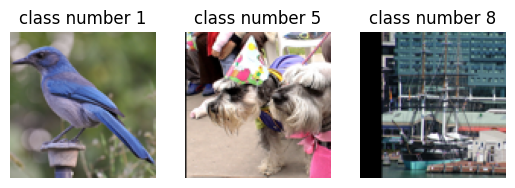

In [3]:
#@title Code for creating dataset

BATCH_SIZE = 50

dataset = datasets.STL10('/content/sample_data', split='train', download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_set_l, train_set_ul = torch.utils.data.random_split(dataset, [500, 4500])
test_set = datasets.STL10('/content/sample_data', split='test', download=False, transform=transforms.Compose([transforms.ToTensor()]))

train_l_loader = DataLoader(train_set_l, batch_size=BATCH_SIZE, shuffle=True)
train_ul_loader = DataLoader(train_set_ul, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

for img, label in train_l_loader:
    print(img.shape, label.shape)
    plt.figure(1)
    plt.subplot(1,3,1)
    plt.imshow(img[0].numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(f"class number {label[0]}")
    plt.subplot(1,3,2)
    plt.imshow(img[1].numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(f"class number {label[1]}")
    plt.subplot(1,3,3)
    plt.imshow(img[2].numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(f"class number {label[2]}")
    break

In [4]:
#@title creating classification network and self-supervised network.

class clf_network(nn.Module):
    def __init__(self):
        super(clf_network, self).__init__()

        r18 = models.resnet18()
        modules = list(r18.children())[:-1]
        self.encoder = nn.Sequential(*modules, nn.Flatten())

        self.classification_head = nn.Sequential(
                nn.Linear(512, 100),
                nn.ReLU(),
                nn.Linear(100, 10))

    def forward(self, x):

      encoder_out = self.encoder(x)
      predictions = self.classification_head(encoder_out)

      return predictions


class ss_network(nn.Module):
    '''
    SSL Pretraining network
    '''
    def __init__(self):
        super(ss_network, self).__init__()

        r18 = models.resnet18()
        modules = list(r18.children())[:-1]
        self.encoder = nn.Sequential(*modules, nn.Flatten())

        self.projection_head = nn.Sequential(
            nn.Linear(512, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 500))

    def forward(self, x):

      representation = self.encoder(x)
      embeddings = self.projection_head(representation)

      return representation, embeddings




In [5]:
#@title Function for evaluating representation quality using a 1-nearest neighbor classifier.

from sklearn.neighbors import KNeighborsClassifier

def to_np(x):
    return x.cpu().detach().numpy()



def evaluate_encoder_representation(model, training_set, test_set):
    '''
    This is a clustering algorithm that can be used to evaluate how well the latent space learned the data
    It can be run every nth epoch during pre training on the labeled training (x_tr_l) an dthe test data (x_te)
    '''

    model.eval()
    model = model.to('cpu')

    N_tr = len(training_set)
    N_te = len(test_set)

    training_generator = DataLoader(training_set, batch_size=1,
                                    shuffle=True, drop_last=False)
    test_generator = DataLoader(test_set, batch_size= 1,
                                    shuffle=True, drop_last=False)

    H_tr = torch.zeros((N_tr, 128))
    y_tr = torch.zeros((N_tr), dtype=torch.long)

    H_te = torch.zeros((N_te, 128))
    y_te = torch.zeros((N_te), dtype=torch.long)

    for idx_tr, (x_tr, y_tr_i) in enumerate(training_generator):
        with torch.no_grad():
            H_tr_i, _  = model(x_tr.float())
            H_tr[idx_tr] = H_tr_i
            y_tr[idx_tr] = y_tr_i

    H_tr = to_np(nn.functional.normalize(H_tr))
    y_tr = to_np(y_tr)

    for idx_te, (x_te, y_te_i) in enumerate(test_generator):
        with torch.no_grad():
            _, H_te_i = model(x_te.float())
            H_te[idx_te] = H_te_i
            y_te[idx_te] = y_te_i

    H_te = to_np(nn.functional.normalize(H_te))
    y_te = to_np(y_te)

    clf = KNeighborsClassifier(n_neighbors=1).fit(H_tr, y_tr)

    return clf.score(H_te, y_te)



#Self-supervised learning using siamese and a contrastive learning

Your task is to implement the following self-supervised frameworks:


*   [SimSiam](https://arxiv.org/abs/2011.10566)
*   [SimCLR](https://arxiv.org/abs/2002.05709)



In [6]:
#@title Augemntation operation
def augment(in_tensor, crop_size=6):
    return transforms.RandomCrop(crop_size)(in_tensor)

'''
transforms = torch.nn.Sequential(
    transforms.CenterCrop(10),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
)
scripted_transforms = torch.jit.script(transforms)
'''

'\ntransforms = torch.nn.Sequential(\n    transforms.CenterCrop(10),\n    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),\n)\nscripted_transforms = torch.jit.script(transforms)\n'

In [ ]:
#@title Contrastive Loss
def sim_score()

In [ ]:
#@title Code for self-supervised pretraining.


from IPython.display import clear_output
EPOCHS = 200
USE_PRETRAINED_WEIGHTS = False


model = ss_network()
model = model.to('cuda')

if USE_PRETRAINED_WEIGHTS:
  model.encoder.load_state_dict("fill name of your network".encoder.state_dict())


LossList, AccuracyList = [], []
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

print('Training starts!')
for epoch in range(EPOCHS):

    model.train()
    optimizer.zero_grad()

    for x_tr_ul, _ in train_ul_loader:
        x_tr_ul = x_tr_ul.to('cuda')

        x_tr_ul_aug1 = augment(x_tr_ul)
        x_tr_ul_aug2 = augment(x_tr_ul)

        '''
        We implement the normalized temperature-scaled cross-entropy loss (see icloud notes or SIMclr paper)
        The cosine similarity returns a similarity matrix between the two batches
        The comparison scores of positive samples lie on the diagonal of the matrix
        The scores of negative samples lie outside
        --> Along the batch dimension pick out the value on the diagonal for positive score s(z_i, z_j)
        and sum up the loss along batch dimension to get negative sample compatrison scaore s(z_i, z_k)

        --> The task can be solved by either making "Zähler" (denominator?), so similarity very large
        or dissimilarity in "nenner" really low
        '''

        h1, _ = model(x_tr_ul_aug1)
        h2, _ = model(x_tr_ul_aug2)

        '''
        h1_norm * h1_norm.T
        '''

        #cos = nn.CosineSimilarity(dim=0)
        #similarity_matrix = cos(h1, h2)

        h1_norm = nn.functional.normalize(h1, dim=1) # Normalize along sample dim (=1), not batch dim!
        h2_norm = nn.functional.normalize(h2, dim=1)
        cosine_similarity_matrix = torch.mm(h2_norm.t(), h1_norm)

        unity = torch.eye(cosine_similarity_matrix.shape[0], cosine_similarity_matrix.shape[1])
        unity = unity.bool()

        positive_comparison_distances = cosine_similarity_matrix[unity]
        # !!! TODO: CHECK WHETHER BELOW WORKS !!!
        cosine_similarity_matrix_unity_zero = cosine_similarity_matrix
        cosine_similarity_matrix_unity_zero[unity] = 0
        # Summing up all negative distances along one sample axis
        negative_comparison_distances = torch.sum(cosine_similarity_matrix_unity_zero, dim=0)
        breakpoint()





        # TODO: implement 2 augmentations!


        #y_tr_pred = model(x_tr)

        #loss = criterion(y_tr_pred, y_tr)
        #loss.backward()
        #optimizer.step()

        #LossList.append(loss.item())

    with torch.no_grad():
        AccListBatch = []
        model.eval()
        for x_te, y_te in test_loader:
            x_te, y_te = x_te.to('cuda'), y_te.to('cuda')
            y_te_pred = model(x_te)
            AccListBatch.append(torch.sum(y_te_pred.argmax(1) == y_te) / len(y_te))
        AccuracyList.append(torch.mean(torch.tensor(AccListBatch)).item())

    if epoch % 10 == 0 and epoch != 0: clear_output()
    print(f"Epoch: {epoch}, loss: {LossList[-1]}, accuracy: {AccuracyList[-1]}")

plt.figure(1, figsize=(8,4))
plt.subplot(121)
plt.plot(LossList, label='loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.subplot(122)
plt.plot(AccuracyList, label='accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()



Training starts!
> <ipython-input-22-073322874993>(26)<cell line: 21>()
     24     optimizer.zero_grad()
     25 
---> 26     for x_tr_ul, _ in train_ul_loader:
     27         x_tr_ul = x_tr_ul.to('cuda')
     28 

ipdb> negative_comparison_distances.SHAPE
*** AttributeError: 'Tensor' object has no attribute 'SHAPE'
ipdb> negative_comparison_distances.shape
torch.Size([512])



# Downstream task: classification.

This notebook contains the second exercise for the NORA research summer school on self-supervised learning. The exercise in this notebook is pre-training a convolutional neural network using contrastive and non-contrastive approaches and fine-tuning the network for classification.

The notebook is seperated into several segments with both complete code and code with missing components. Your job is to fill in the missing component.

Remember to enable GPU processing: edit -> notebook settings -> hardware accelerator -> GPU.


In [8]:
#@title Training code for downstream task.

from IPython.display import clear_output
EPOCHS = 200
USE_PRETRAINED_WEIGHTS = False

model = clf_network().to('cuda')

if USE_PRETRAINED_WEIGHTS:
  model.encoder.load_state_dict("fill name of your network".encoder.state_dict())


LossList, AccuracyList = [], []
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

print('Training starts!')
for epoch in range(EPOCHS):

    model.train()
    optimizer.zero_grad()

    for x_tr, y_tr in train_l_loader:
        x_tr, y_tr = x_tr.to('cuda'), y_tr.to('cuda')

        y_tr_pred = model(x_tr)

        loss = criterion(y_tr_pred, y_tr)
        loss.backward()
        optimizer.step()

        LossList.append(loss.item())

    with torch.no_grad():
        AccListBatch = []
        model.eval()
        for x_te, y_te in test_loader:
            x_te, y_te = x_te.to('cuda'), y_te.to('cuda')
            y_te_pred = model(x_te)
            AccListBatch.append(torch.sum(y_te_pred.argmax(1) == y_te) / len(y_te))
        AccuracyList.append(torch.mean(torch.tensor(AccListBatch)).item())

    if epoch % 10 == 0 and epoch != 0: clear_output()
    print(f"Epoch: {epoch}, loss: {LossList[-1]}, accuracy: {AccuracyList[-1]}")

plt.figure(1, figsize=(8,4))
plt.subplot(121)
plt.plot(LossList, label='loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.subplot(122)
plt.plot(AccuracyList, label='accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

Training starts!
Epoch: 0, loss: 2.167044162750244, accuracy: 0.10212500393390656
Epoch: 1, loss: 2.1528475284576416, accuracy: 0.10012499988079071
Epoch: 2, loss: 3.1837079524993896, accuracy: 0.14299999177455902


KeyboardInterrupt: ignored